# **Triage Dental Difuso**

### Curso: Sistemas Inteligentes

### Grupo 10
**Integrantes:**

- Mejía Carrasco, Marlo Gabriel
- Rezza Valencia, Francesca Renee
- Serrato Vargas, José Eduardo

**Objetivo**: Implementar un sistema de triage dental (educativo) usando la librería personalizada `fuzzy.py` (funciones de membresía, corte, unión y desfuzzificación).

In [26]:
# Librerías requeridas
import numpy as np
from matplotlib import pyplot as plt 
from fuzzy import *

## 1) Definición de variables lingüísticas (entradas y salidas)

In [17]:
# Entradas (universos de discurso)
# - dolor_intensidad (0–10)
# - sensibilidad_frio (0–10)
# - sangrado_cepillado (0–100 %)
# - placa_indice (0–3)  (p.ej., OHI-S simplificado)
# - profundidad_sondaje (0–10 mm)

dolor = np.linspace(0, 10, 100)
frio  = np.linspace(0, 10, 100)
sang  = np.linspace(0, 100, 300)
placa = np.linspace(0, 3, 300)
sond  = np.linspace(0, 10, 100)

# Salidas (0–100): riesgo_caries, riesgo_gingivitis, riesgo_periodontitis, urgencia
y = np.linspace(0, 100, 401)

In [27]:
# Funciones de membresía de ENTRADAS (triangulares/trapezoidales)

# dolor_intensidad (0-10)
D_bajo  = trapmf(dolor, [0, 0, 3, 5])
D_medio = trimf(dolor, [3, 5, 7])
D_alto  = trapmf(dolor, [5, 7, 10, 10])

# sensibilidad_frio (0-10)
F_bajo  = trapmf(frio, [0, 0, 3, 5])
F_medio = trimf(frio, [3, 5, 7])
F_alto  = trapmf(frio, [5, 7, 10, 10])

# sangrado_cepillado (0-100 %)
S_nulo     = trapmf(sang, [0, 0, 20, 40])
S_leve     = trimf(sang, [20, 40, 60])
S_moderado = trimf(sang, [40, 60, 80])
S_severo   = trapmf(sang, [60, 80, 100, 100])

# placa_indice (0-3)
P_bajo  = trapmf(placa, [0.0, 0.0, 1.0, 1.5])
P_medio = trimf(placa, [1.0, 1.5, 2.0])
P_alto  = trapmf(placa, [1.5, 2.0, 3.0, 3.0])

# profundidad_sondaje (0-10 mm)
R_normal    = trapmf(sond, [0, 0, 3, 5])
R_moderada  = trimf(sond, [3, 5, 7])
R_profunda  = trapmf(sond, [5, 7, 10, 10])

In [19]:
# Funciones de membresía de SALIDAS (0-100): bajo / medio / alto
OUT_bajo  = trapmf(y, [0, 0, 20, 35])
OUT_medio = trimf(y, [30, 50, 70])
OUT_alto  = trapmf(y, [65, 80, 100, 100])

### Graficar funciones de membresía

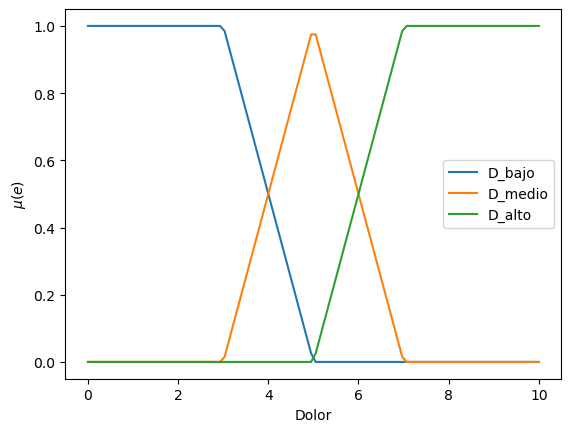

In [20]:
plt.plot(dolor, D_bajo, label="D_bajo")
plt.plot(dolor, D_medio, label="D_medio")
plt.plot(dolor, D_alto, label="D_alto")
plt.legend(loc='best')
plt.xlabel('Dolor')
plt.ylabel('$\mu (e)$')
plt.show()

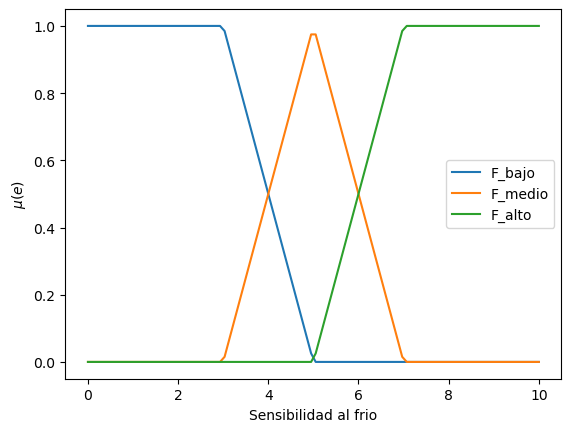

In [21]:
plt.plot(frio, F_bajo, label="F_bajo")
plt.plot(frio, F_medio, label="F_medio")
plt.plot(frio, F_alto, label="F_alto")
plt.legend(loc='best')
plt.xlabel('Sensibilidad al frio')
plt.ylabel('$\mu (e)$')
plt.show()

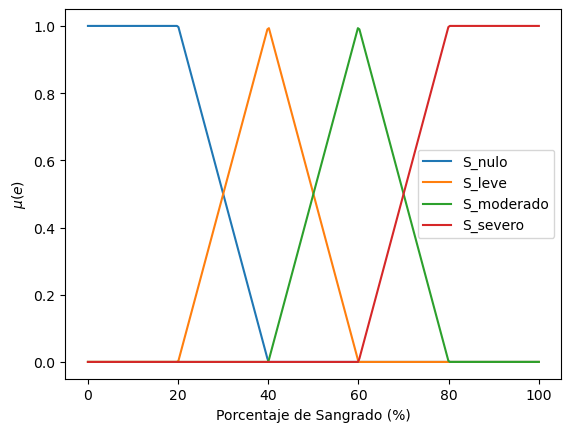

In [22]:
plt.plot(sang, S_nulo, label="S_nulo")
plt.plot(sang, S_leve, label="S_leve")
plt.plot(sang, S_moderado, label="S_moderado")
plt.plot(sang, S_severo, label="S_severo")
plt.legend(loc='best')
plt.xlabel('Porcentaje de Sangrado (%)')
plt.ylabel('$\mu (e)$')
plt.show()

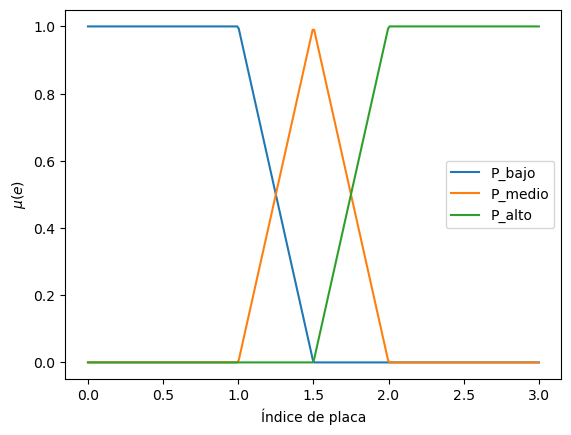

In [23]:
plt.plot(placa, P_bajo, label="P_bajo")
plt.plot(placa, P_medio, label="P_medio")
plt.plot(placa, P_alto, label="P_alto")
plt.legend(loc='best')
plt.xlabel('Índice de placa')
plt.ylabel('$\mu (e)$')
plt.show()

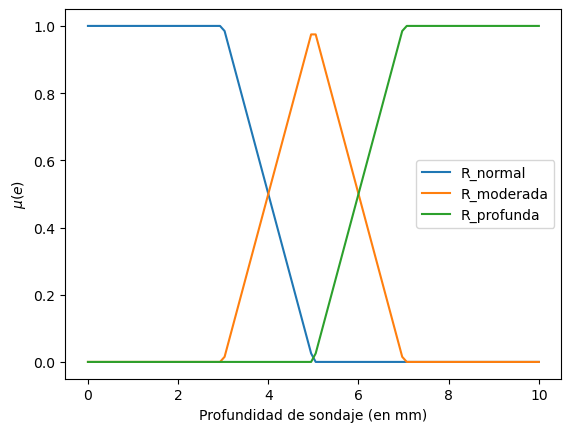

In [24]:
plt.plot(sond, R_normal, label="R_normal")
plt.plot(sond, R_moderada, label="R_moderada")
plt.plot(sond, R_profunda, label="R_profunda")
plt.legend(loc='best')
plt.xlabel('Profundidad de sondaje (en mm)')
plt.ylabel('$\mu (e)$')
plt.show()


## 2) Base de reglas (Mamdani, implicación min, agregación max)

Definimos reglas para cuatro salidas:
- **riesgo_caries**
- **riesgo_gingivitis**
- **riesgo_periodontitis**
- **urgencia** (derivada de condiciones de dolor y severidad)


In [28]:
# Helper: evalúa antecedentes de una regla tipo min(a1, a2, ...)
def rule_strength(*vals):
    return min(vals)

# Dado un firing strength α y una MF de salida, devuelve la MF "cortada"
def apply_rule(alpha, out_mf):
    """
    alpha: firing strength (escalar)
    out_mf: numpy.ndarray con valores de la MF sobre el universo y
    Devuelve: MF recortada (array)
    """
    return cut(alpha, out_mf)


# Combina (unión por máximo) una lista de MF de salida
def aggregate(mf_list):
    return union(mf_list) if mf_list else np.zeros_like(y)

In [29]:
# helper: crea una función que evalúa una MF (array) en un valor escalar mediante interpolación
def mk_fn(universe, mf_array):
    return lambda v: float(np.interp(v, universe, mf_array))

# Ejemplo: si antes tenías
# P_bajo  = trapmf(placa, [0.0, 0.0, 1.0, 1.5])
# P_medio = trimf(placa, [1.0, 1.5, 2.0])
# P_alto  = trapmf(placa, [1.5, 2.0, 3.0, 3.0])
#
# añade inmediatamente después:

P_bajo = mk_fn(placa, P_bajo)
P_medio = mk_fn(placa, P_medio)
P_alto  = mk_fn(placa, P_alto)

# Repite lo mismo para las entradas dolor/frio/sang/sondaje, por ejemplo:
D_bajo  = mk_fn(dolor, D_bajo)
D_medio = mk_fn(dolor, D_medio)
D_alto  = mk_fn(dolor, D_alto)

F_bajo  = mk_fn(frio, F_bajo)   # <-- fíjate que 'frio' (no 'dolor') debe usarse aquí
F_medio = mk_fn(frio, F_medio)
F_alto  = mk_fn(frio, F_alto)

S_nulo     = mk_fn(sang, S_nulo)
S_leve     = mk_fn(sang, S_leve)
S_moderado = mk_fn(sang, S_moderado)
S_severo   = mk_fn(sang, S_severo)

R_normal   = mk_fn(sond, R_normal)
R_moderada = mk_fn(sond, R_moderada)
R_profunda = mk_fn(sond, R_profunda)


In [36]:
def eval_caries(d, f, p):
    # Reglas para riesgo_caries
    # 1) Si placa es alto ∧ sensibilidad es alta → caries alto
    r1 = apply_rule(rule_strength(P_alto(p), F_alto(f)), OUT_alto)
    # 2) Si placa es medio ∧ sensibilidad es media → caries medio
    r2 = apply_rule(rule_strength(P_medio(p), F_medio(f)), OUT_medio)
    # 3) Si placa es bajo ∧ sensibilidad es baja → caries bajo
    r3 = apply_rule(rule_strength(P_bajo(p), F_bajo(f)), OUT_bajo)
    return aggregate([r1, r2, r3])

def eval_gingivitis(s, p):
    # Reglas para riesgo_gingivitis
    # 4) sangrado severo ∧ placa alta → alto
    r4 = apply_rule(rule_strength(S_severo(s), P_alto(p)), OUT_alto)
    # 5) sangrado moderado → medio
    r5 = apply_rule(S_moderado(s), OUT_medio)
    # 6) sangrado nulo → bajo
    r6 = apply_rule(S_nulo(s), OUT_bajo)
    return aggregate([r4, r5, r6])

def eval_periodontitis(sondaje, s):
    # Reglas para riesgo_periodontitis
    # 7) sondaje profundo ∧ (sangrado moderado o severo) → alto
    r7 = apply_rule(rule_strength(R_profunda(sondaje), max(S_moderado(s), S_severo(s))), OUT_alto)
    # 8) sondaje moderado ∧ (sangrado leve o moderado) → medio
    r8 = apply_rule(rule_strength(R_moderada(sondaje), max(S_leve(s), S_moderado(s))), OUT_medio)
    # 9) sondaje normal → bajo
    r9 = apply_rule(R_normal(sondaje), OUT_bajo)
    return aggregate([r7, r8, r9])

def eval_urgencia(d, f, sondaje, s, p):
    # Reglas para urgencia
    # 10) dolor alto ∧ sensibilidad alta → alto
    u1 = apply_rule(rule_strength(D_alto(d), F_alto(f)), OUT_alto)
    # 11) dolor medio OR sondaje profundo → medio (usamos max para OR)
    u2_alpha = max(D_medio(d), R_profunda(sondaje))
    u2 = apply_rule(u2_alpha, OUT_medio)
    # 12) todo bajo/normal → bajo (aproximación usando AND de varios términos)
    u3 = apply_rule(rule_strength(D_bajo(d), F_bajo(f), S_nulo(s), P_bajo(p), R_normal(sondaje)), OUT_bajo)
    return aggregate([u1, u2, u3])

## 3) Evaluación y desfuzzificación (centroide)

In [37]:

def inferir(dolor0, frio0, sang0, placa0, sondaje0, metodo='centroid'):
    # 1) Agregación por salida
    mf_caries  = eval_caries(dolor0, frio0, placa0)
    mf_ginv    = eval_gingivitis(sang0, placa0)
    mf_perio   = eval_periodontitis(sondaje0, sang0)
    mf_urg     = eval_urgencia(dolor0, frio0, sondaje0, sang0, placa0)

    # 2) Desfuzzificación
    c_val   = defuzz(y, mf_caries, metodo)
    g_val   = defuzz(y, mf_ginv,   metodo)
    p_val   = defuzz(y, mf_perio,  metodo)
    u_val   = defuzz(y, mf_urg,    metodo)

    return (c_val, g_val, p_val, u_val), (mf_caries, mf_ginv, mf_perio, mf_urg)

### 4) Ejemplo de prueba

In [38]:
# Caso de ejemplo (puedes modificar estos valores)
dolor0   = 7.5   # 0–10
frio0    = 6.0   # 0–10
sang0    = 40.0  # 0–100 %
placa0   = 2.3   # 0–3
sondaje0 = 5.8   # 0–10 mm

(vals, mfs) = inferir(dolor0, frio0, sang0, placa0, sondaje0, metodo='centroid')
caries_val, ginv_val, perio_val, urg_val = vals
print(f"Riesgo caries:       {caries_val:.2f}")
print(f"Riesgo gingivitis:   {ginv_val:.2f}")
print(f"Riesgo periodontitis:{perio_val:.2f}")
print(f"Urgencia:            {urg_val:.2f}")

Riesgo caries:       84.36
Riesgo gingivitis:   34.87
Riesgo periodontitis:50.25
Urgencia:            68.94


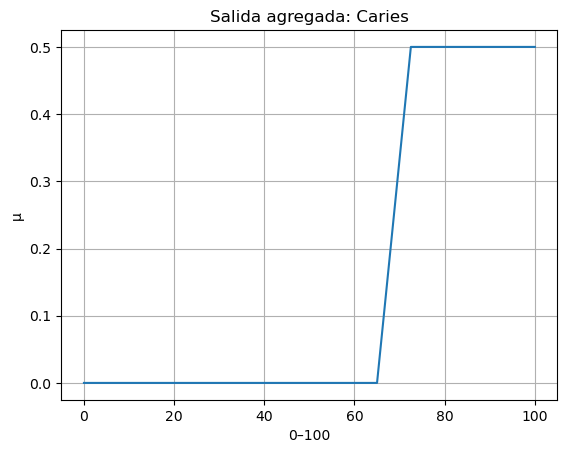

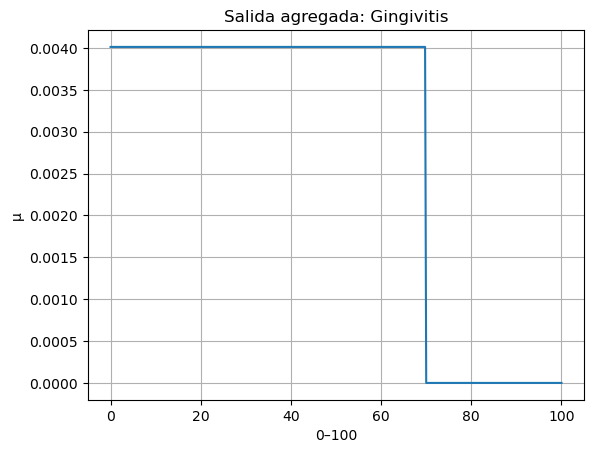

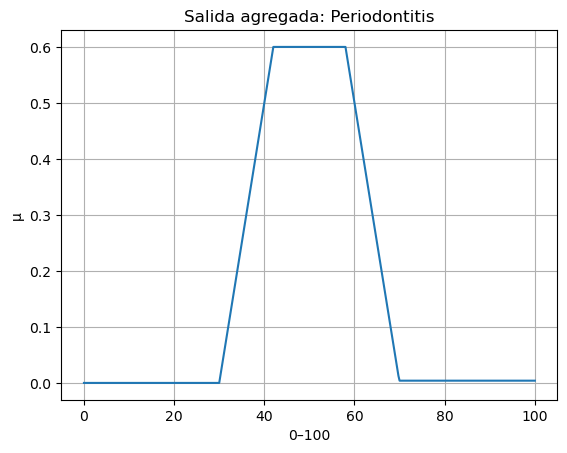

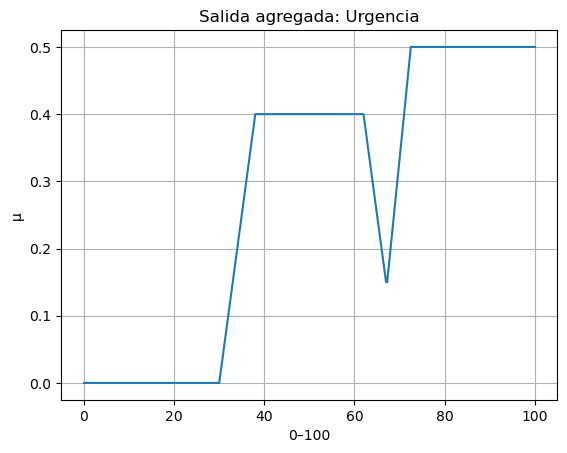

In [39]:

# Visualizar las funciones agregadas de salida
labels = ["Caries", "Gingivitis", "Periodontitis", "Urgencia"]
colors = [None, None, None, None]  # usar colores por defecto de Matplotlib

for (mf, lab) in zip(mfs, labels):
    plt.figure()
    plt.plot(y, mf)
    plt.title(f"Salida agregada: {lab}")
    plt.xlabel("0–100")
    plt.ylabel("μ")
    plt.grid(True)
    plt.show()


### 5) Recomendación simple (opcional)

In [40]:

def recomendacion(urg):
    if urg >= 70:
        return "Atención inmediata (24–48 h)"
    elif urg >= 40:
        return "Priorizar cita (≤ 7 días)"
    else:
        return "Control rutinario"
print("Recomendación:", recomendacion(urg_val))


Recomendación: Priorizar cita (≤ 7 días)



---

**Siguientes pasos (opcional):**
- Afinar parámetros de membresía con juicio experto.
- Añadir variables (p. ej., sensibilidad al calor, halitosis) o reglas adicionales.
- Comparar centroid vs. MOM/SOM/LOM usando `defuzz`.
